

Because the computation is quite costly and complex it has been broken down into multiple steps. This 

In [1]:
# load the modules we'll need

import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skimage.color

import genesis
import genesis.objects
import genesis.utils
import genesis.utils.mask_functions

%matplotlib inline

genesis.__version__

'0.1.0'

In [2]:
# open all 3D files into one xarray Dataset
ds = xr.open_mfdataset('../fixed_flux_noshear__nx800/3d_blocks/full_domain/*.nc', combine='by_coords')

In [3]:
# center all the staggered velocity fields (otherwise we won't be able 
# to look at their covariance with other fields)
ds['u'] = genesis.utils.center_staggered_field(ds.u)
ds['v'] = genesis.utils.center_staggered_field(ds.v)
ds['w'] = genesis.utils.center_staggered_field(ds.w)

## Identify region of boundary layer containing coherent structures

In [4]:
mask = genesis.utils.mask_functions.rad_tracer_thermals(
    base_name='fixed_flux_noshear', cvrxp=ds.cvrxp, num_std_div=2.0
)

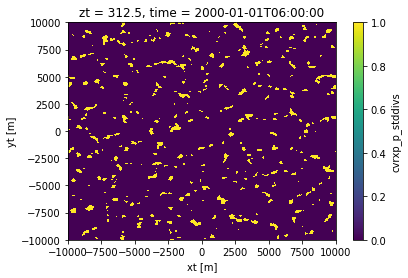

In [5]:
mask.sel(zt=300, method='nearest').plot()

## Split mask into individual objects

In [6]:
splitting_scalar = ds.w
object_labels = genesis.objects.identify.label_objects(mask=mask, splitting_scalar=splitting_scalar)

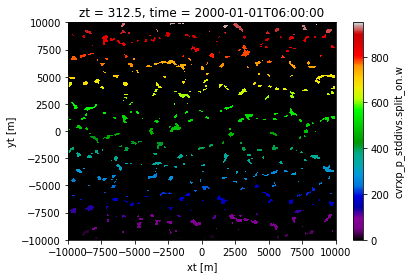

In [7]:
object_labels.sel(zt=300, method='nearest').plot(cmap='nipy_spectral')

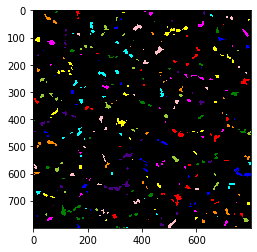

In [8]:
# use skimage to create individual colors for each object
v = object_labels.sel(zt=300, method='nearest').values
plt.imshow(skimage.color.label2rgb(v, bg_label=0))

# Integrate over objects to find characteristic properties

In [9]:
help(genesis.objects.integrate.integrate)

Help on function integrate in module genesis.objects.integrate:

integrate(objects, variable, operator=None, **kwargs)
    Integrate over the labelled objects in `objects` the variable (named by a
    string, .e.g `r_equiv` would be the equivalent spherical radius). Can also
    integrate for example a scalar field provided through an extra kwarg to
    find for example the maximum value.
    
    Available variables:
    
        length_m, width_m, thickness_m, num_cells, volume, filamentarity, planarity, theta, phi, x_c, y_c, z_c
    
    Calculating equivalent radius for each object:
    
    >> integrate(da_objects, variable='r_equiv')
    
    Calculate the maximum value of vertical velocity for each object
    
    >> integrate(da_objects, variable='w', operator='maximum', w=da_w)
    
    Calculate the volume integral of water vapour for each object
    
    >> integrate(da_objects, variable='q', operator='volume_integral', q=ds.q)



In [10]:
da_r_equiv = genesis.objects.integrate.integrate(object_labels, 'r_equiv', None)

(array([489., 201., 105.,  54.,  35.,  36.,  13.,  11.,   7.,   5.]),
 array([ 15.50876227,  71.22414279, 126.93952332, 182.65490384,
        238.37028436, 294.08566488, 349.8010454 , 405.51642592,
        461.23180645, 516.94718697, 572.66256749]),
 <a list of 10 Patch objects>)

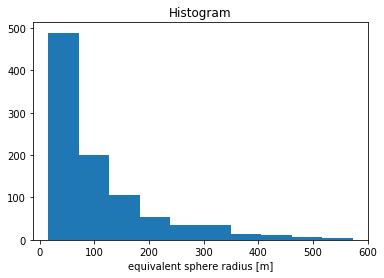

In [11]:
da_r_equiv.plot.hist()

In [12]:
da_w_max = genesis.objects.integrate.integrate(object_labels, 'w', 'maximum', w=ds.w)

(array([  4.,   5.,  42., 329., 196.,  27.,   3.,   3.,   1.,   3.]),
 array([-1.3894318 , -0.7689844 , -0.14853697,  0.47191048,  1.0923579 ,
         1.7128053 ,  2.3332527 ,  2.9537003 ,  3.5741477 ,  4.194595  ,
         4.8150425 ], dtype=float32),
 <a list of 10 Patch objects>)

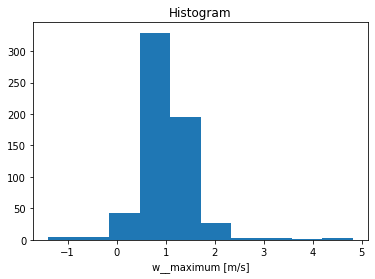

In [13]:
da_w_max.plot.hist()

In [14]:
# Does the radius and maximum vertical velocity correlate?
ds_scales = xr.merge([da_r_equiv, da_w_max])
ds_scales

<xarray.Dataset>
Dimensions:     (object_id: 956)
Coordinates:
  * object_id   (object_id) int64 1 2 3 4 5 6 7 ... 950 951 952 953 954 955 956
Data variables:
    r_equiv     (object_id) float64 61.71 234.8 214.8 ... 26.52 35.51 19.54
    w__maximum  (object_id) float32 nan nan 1.047081 ... 0.77299404 0.9419681

Text(27.125, 0.5, 'w__maximum [m/s]')

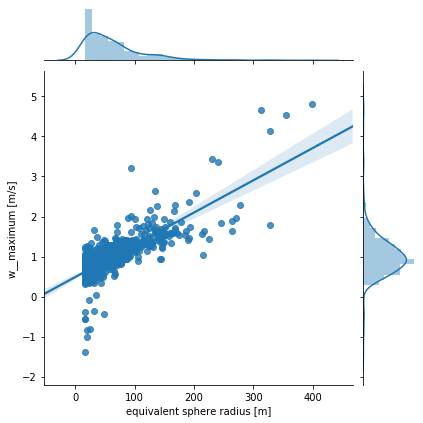

In [15]:
sns.jointplot('r_equiv', 'w__maximum', data=ds_scales, kind='reg')
ax = plt.gca()
ax.set_xlabel(xr.plot.utils.label_from_attrs(ds_scales.r_equiv))
ax.set_ylabel(xr.plot.utils.label_from_attrs(ds_scales.w__maximum))

There does appear to be a correlation so that the largest objects have the largest vertical velocity

In [16]:
da_length_m = genesis.objects.integrate.integrate(object_labels, 'length_m')
da_width_m = genesis.objects.integrate.integrate(object_labels, 'width_m')

In [17]:
filter_nan_and_inf = lambda da: da.where((~np.isnan(da)) & (~np.isinf(da)))

(array([522., 178.,  77.,  36.,  33.,  17.,  12.,  11.,   6.,  16.,   6.,
          2.,   1.,   2.,   4.,   1.,   1.,   2.,   1.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   2.]),
 array([  12.5    ,   95.27779,  178.05557,  260.83334,  343.61115,
         426.38892,  509.1667 ,  591.94446,  674.7223 ,  757.50006,
         840.27783,  923.0556 , 1005.8334 , 1088.6112 , 1171.3889 ,
        1254.1667 , 1336.9446 , 1419.7223 , 1502.5001 , 1585.2778 ,
        1668.0557 , 1750.8335 , 1833.6112 , 1916.389  , 1999.1667 ,
        2081.9446 , 2164.7224 , 2247.5002 , 2330.2778 , 2413.0557 ,
        2495.8335 ], dtype=float32),
 <a list of 30 Patch objects>)

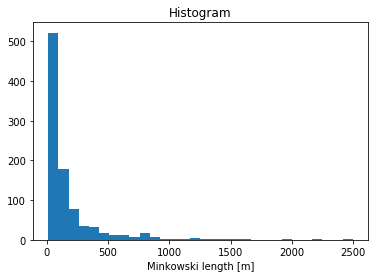

In [18]:
filter_nan_and_inf(da_length_m).plot.hist(bins=30)

In [19]:
# calculate filamentarity and planarity from Minkowski functionals
da_filamentarity = genesis.objects.integrate.integrate(object_labels, 'filamentarity')
da_planarity = genesis.objects.integrate.integrate(object_labels, 'planarity')

In [20]:
ds_scales = xr.merge([da_r_equiv, da_w_max, da_length_m, da_width_m, da_filamentarity, da_planarity])
ds_scales['dataset'] = 'fixed_flux_noshear'
ds_scales = ds_scales.expand_dims('dataset')
ds_scales

<xarray.Dataset>
Dimensions:        (dataset: 1, object_id: 956)
Coordinates:
  * object_id      (object_id) int64 1 2 3 4 5 6 7 ... 951 952 953 954 955 956
Dimensions without coordinates: dataset
Data variables:
    r_equiv        (dataset, object_id) float64 61.71 234.8 ... 35.51 19.54
    w__maximum     (dataset, object_id) float32 nan nan ... 0.77299404 0.9419681
    length_m       (dataset, object_id) float32 70.833336 ... 16.666666
    width_m        (dataset, object_id) float32 61.789616 ... 19.894384
    filamentarity  (dataset, object_id) float32 0.068191215 ... -0.08828298
    planarity      (dataset, object_id) float32 0.07010941 ... -0.061461337
    dataset        (dataset) <U18 'fixed_flux_noshear'

In [21]:
genesis.objects.topology.plots.filamentarity_planarity(ds_scales)

NameError: name 'x' is not defined